In [1]:
# Import the modules at the beginning

import pandas as pd
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np


In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Data Preparation

In [3]:
df = pd.read_csv('data.csv', encoding = 'latin1') #Without encoding you'll get an error

In [4]:
df.shape

(1303, 13)

In [5]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


## 1.2 Data Cleaning

Columns and Categorical values are not in uniform order

In [6]:
# Make the column in order
df.columns = df.columns.str.lower()

In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower().str.replace('  ', ' ').str.replace(' ', '_')

In [8]:
df.rename(columns={'ram':'ram_in_gb', 'weight': 'weight_in_kg', 'typename':'type_name', 'screenresolution':'screen_resolution', 'opsys': 'op_sys'}, inplace=True)

In [9]:
df.columns

Index(['laptop_id', 'company', 'product', 'type_name', 'inches',
       'screen_resolution', 'cpu', 'ram_in_gb', 'memory', 'gpu', 'op_sys',
       'weight_in_kg', 'price_euros'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   laptop_id          1303 non-null   int64  
 1   company            1303 non-null   object 
 2   product            1303 non-null   object 
 3   type_name          1303 non-null   object 
 4   inches             1303 non-null   float64
 5   screen_resolution  1303 non-null   object 
 6   cpu                1303 non-null   object 
 7   ram_in_gb          1303 non-null   object 
 8   memory             1303 non-null   object 
 9   gpu                1303 non-null   object 
 10  op_sys             1303 non-null   object 
 11  weight_in_kg       1303 non-null   object 
 12  price_euros        1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


Let's have more numerical coumns

In [11]:
df['ram_in_gb'] = df['ram_in_gb'].str.replace('gb', '')

df['ram_in_gb'] = pd.to_numeric(df.ram_in_gb, errors='coerce')

df['weight_in_kg'] = df['weight_in_kg'].str.replace('kg', '')

df['weight_in_kg'] = pd.to_numeric(df.weight_in_kg, errors='coerce')

## 2. Exploratory Data Analysis


My input data was like this, so which tells me that need more cleaning

 `{'company': 'dell',
 'product': 'xps_13',
 'type_name': 'ultrabook',
 'inches': 13.3,
 'screen_resolution': 'full_hd_1920x1080',
 'cpu': 'intel_core_i7_7560u_2.4ghz',
 'ram_in_gb': 8,
 'memory': '256gb_ssd',
 'gpu': 'intel_iris_plus_graphics_640',
 'op_sys': 'windows_10',
 'weight_in_kg': 1.23}`
 
My desired input value like this

`{'company': 'dell',
 'type_name': 'ultrabook',
 'inches': 13.3,
 'screen_resolution': '1920x1080',
 'screen_resolution_type': 'full_hd',
 'touch_screen': 1,
 'processor': 'intel_core_i7',
 'clock_speed_ghz': 2.4,
 'ram_in_gb': 8,
 'memory_gb': 256,
 'hard_disk_type': 'ssd',
 'gpu': 'intel_iris_plus_graphics_640',
 'op_sys': 'windows_10',
 'weight_in_kg': 1.23}`
 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   laptop_id          1303 non-null   int64  
 1   company            1303 non-null   object 
 2   product            1303 non-null   object 
 3   type_name          1303 non-null   object 
 4   inches             1303 non-null   float64
 5   screen_resolution  1303 non-null   object 
 6   cpu                1303 non-null   object 
 7   ram_in_gb          1303 non-null   int64  
 8   memory             1303 non-null   object 
 9   gpu                1303 non-null   object 
 10  op_sys             1303 non-null   object 
 11  weight_in_kg       1303 non-null   float64
 12  price_euros        1303 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 132.5+ KB


In [13]:
screen_split = df['screen_resolution'].str.split('x', expand=True)
df['y_res'] = screen_split[1]
df['x_res'] = screen_split[0].str.replace(',','').str.findall(r'(\d+\.?\d+)').apply(lambda x: pd.Series(x).astype(int))

In [14]:
df['touch_screen'] = df['screen_resolution'].str.contains('touchscreen').astype('int32')
df['screen_resolution_type'] = df['screen_resolution'].str.findall(r'(full_hd|4k)').apply(lambda x: pd.Series(x))

In [15]:
cpu_split = df['cpu'].str.split(r'(\d[\.\d]*)ghz').apply(lambda x: pd.Series(x))

In [16]:
df['processor'], df['clock_speed_ghz'] = cpu_split[0].str.strip('_'), cpu_split[1]

In [17]:
df['processor'].value_counts()

intel_core_i5_7200u       193
intel_core_i7_7700hq      147
intel_core_i7_7500u       135
intel_core_i3_6006u        81
intel_core_i7_8550u        73
                         ... 
intel_xeon_e3-1535m_v6      1
intel_core_m_7y30           1
intel_core_i7_6920hq        1
amd_e-series_e2-6110        1
intel_core_i5_7500u         1
Name: processor, Length: 91, dtype: int64

In [18]:
df['hard_disk_type'] = df.memory.apply(lambda x: 'hybrid' if (('ssd' in x and 'hdd' in x) or 'hybrid' in x) else 'ssd' if 'ssd' in x else 'hdd')
memory_split = df['memory'].str.split('+', expand=True)
df['primary_memory'] = memory_split[0].str.findall(r'([\d\.]+[gb|tb]*)').apply(lambda x: pd.Series(x))[0]
df['primary_memory'] = df['primary_memory'].str.replace('1.0tb', '1tb')
df['primary_memory'].fillna('0gb', inplace=True)
df['primary_memory'] = df['primary_memory'].apply(lambda x:  int(x.replace('tb', '')) * 1000 if 'tb' in x else int(x.replace('gb', '')) if 'gb' in x else int(x))
df['secondary_memory'] = memory_split[1].str.findall(r'([\d\.]+[gb|tb]*)').apply(lambda x: pd.Series(x))[0]
df['secondary_memory'] = df['secondary_memory'].str.replace('1.0tb', '1tb')
df['secondary_memory'].fillna('0gb', inplace=True)
df['secondary_memory'] = df['secondary_memory'].apply(lambda x:  int(x.replace('tb', '')) * 1000 if 'tb' in x else int(x.replace('gb', '')) if 'gb' in x else int(x))
df['memory_gb'] = df['primary_memory'] + df['secondary_memory']

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   laptop_id               1303 non-null   int64  
 1   company                 1303 non-null   object 
 2   product                 1303 non-null   object 
 3   type_name               1303 non-null   object 
 4   inches                  1303 non-null   float64
 5   screen_resolution       1303 non-null   object 
 6   cpu                     1303 non-null   object 
 7   ram_in_gb               1303 non-null   int64  
 8   memory                  1303 non-null   object 
 9   gpu                     1303 non-null   object 
 10  op_sys                  1303 non-null   object 
 11  weight_in_kg            1303 non-null   float64
 12  price_euros             1303 non-null   float64
 13  y_res                   1303 non-null   object 
 14  x_res                   1303 non-null   

Remove the unwanted columns since its not neccessary

In [20]:
df = df.drop(['memory', 'primary_memory', 'secondary_memory', 'screen_resolution'], axis=True)

In [21]:
df.head()

,laptop_id,company,product,type_name,inches,cpu,ram_in_gb,gpu,op_sys,weight_in_kg,price_euros,y_res,x_res,touch_screen,screen_resolution_type,processor,clock_speed_ghz,hard_disk_type,memory_gb
0,1,apple,macbook_pro,ultrabook,13.3,intel_core_i5_2.3ghz,8,intel_iris_plus_graphics_640,macos,1.37,1339.69,1600,2560,0,NaN,intel_core_i5,2.3,ssd,128
1,2,apple,macbook_air,ultrabook,13.3,intel_core_i5_1.8ghz,8,intel_hd_graphics_6000,macos,1.34,898.94,900,1440,0,NaN,intel_core_i5,1.8,hdd,128
2,3,hp,250_g6,notebook,15.6,intel_core_i5_7200u_2.5ghz,8,intel_hd_graphics_620,no_os,1.86,575.00,1080,1920,0,full_hd,intel_core_i5_7200u,2.5,ssd,256
3,4,apple,macbook_pro,ultrabook,15.4,intel_core_i7_2.7ghz,16,amd_radeon_pro_455,macos,1.83,2537.45,1800,2880,0,NaN,intel_core_i7,2.7,ssd,512
4,5,apple,macbook_pro,ultrabook,13.3,intel_core_i5_3.1ghz,8,intel_iris_plus_graphics_650,macos,1.37,1803.60,1600,2560,0,NaN,intel_core_i5,3.1,ssd,256


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   laptop_id               1303 non-null   int64  
 1   company                 1303 non-null   object 
 2   product                 1303 non-null   object 
 3   type_name               1303 non-null   object 
 4   inches                  1303 non-null   float64
 5   cpu                     1303 non-null   object 
 6   ram_in_gb               1303 non-null   int64  
 7   gpu                     1303 non-null   object 
 8   op_sys                  1303 non-null   object 
 9   weight_in_kg            1303 non-null   float64
 10  price_euros             1303 non-null   float64
 11  y_res                   1303 non-null   object 
 12  x_res                   1303 non-null   int32  
 13  touch_screen            1303 non-null   int32  
 14  screen_resolution_type  886 non-null    

In [23]:
# base feature(numerical + categorical)
features = df.columns

# Split the columns based on the value attribute
numerical = list(df.dtypes[df.dtypes != 'object'].index)
categorical = list(df.dtypes[df.dtypes == 'object'].index)

OH! It contains both numerical and categorical values

In [24]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())

laptop_id
[1 2 3 4 5]
1303
company
['apple' 'hp' 'acer' 'asus' 'dell']
19
product
['macbook_pro' 'macbook_air' '250_g6' 'aspire_3' 'zenbook_ux430un']
576
type_name
['ultrabook' 'notebook' 'netbook' 'gaming' '2_in_1_convertible']
6
inches
[13.3 15.6 15.4 14.  12. ]
18
cpu
['intel_core_i5_2.3ghz' 'intel_core_i5_1.8ghz'
 'intel_core_i5_7200u_2.5ghz' 'intel_core_i7_2.7ghz'
 'intel_core_i5_3.1ghz']
116
ram_in_gb
[ 8 16  4  2 12]
9
gpu
['intel_iris_plus_graphics_640' 'intel_hd_graphics_6000'
 'intel_hd_graphics_620' 'amd_radeon_pro_455'
 'intel_iris_plus_graphics_650']
110
op_sys
['macos' 'no_os' 'windows_10' 'mac_os_x' 'linux']
9
weight_in_kg
[1.37 1.34 1.86 1.83 2.1 ]
171
price_euros
[1339.69  898.94  575.   2537.45 1803.6 ]
791
y_res
['1600' '900' '1080' '1800' '768']
10
x_res
[2560 1440 1920 2880 1366]
13
touch_screen
[0 1]
2
screen_resolution_type
[nan 'full_hd' '4k']
2
processor
['intel_core_i5' 'intel_core_i5_7200u' 'intel_core_i7'
 'amd_a9-series_9420' 'intel_core_i7_8550u']
91
clock

<AxesSubplot:xlabel='price_euros', ylabel='Density'>

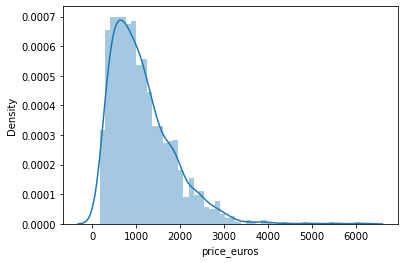

In [25]:
sns.distplot(df.price_euros, bins=50)

<AxesSubplot:xlabel='price_euros', ylabel='Density'>

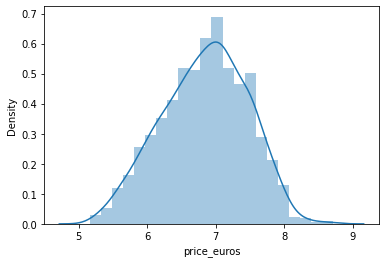

In [26]:
sns.distplot(np.log1p(df.price_euros))

It shows it follows Normal Distribution

<AxesSubplot:>

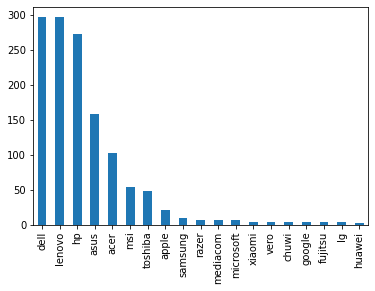

In [27]:
display(df['company'].value_counts().plot(kind='bar'))

<AxesSubplot:>

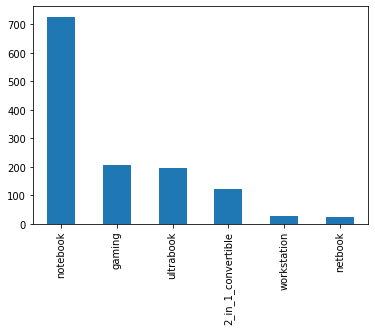

In [28]:
display(df['type_name'].value_counts().plot(kind='bar'))

<AxesSubplot:>

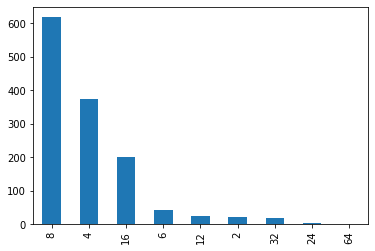

In [29]:
display(df['ram_in_gb'].value_counts().plot(kind='bar'))

<AxesSubplot:>

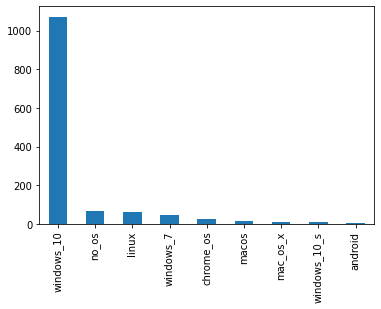

In [30]:
display(df['op_sys'].value_counts().plot(kind='bar'))

### **2.1 Missing values**

In [31]:
df.isnull().sum()

laptop_id                   0
company                     0
product                     0
type_name                   0
inches                      0
cpu                         0
ram_in_gb                   0
gpu                         0
op_sys                      0
weight_in_kg                0
price_euros                 0
y_res                       0
x_res                       0
touch_screen                0
screen_resolution_type    417
processor                   0
clock_speed_ghz             0
hard_disk_type              0
memory_gb                   0
dtype: int64

In [32]:
df['screen_resolution_type'].fillna('hd_ready', inplace=True)

Great! no missing values

### **2.2 Feature Importance Analysis**

**Categorical Features**

In [33]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df['above_average'])

In [34]:
df['above_average'] = (df.price_euros >= 1123).astype(int)

In [35]:
df.head()

,laptop_id,company,product,type_name,inches,cpu,ram_in_gb,gpu,op_sys,weight_in_kg,price_euros,y_res,x_res,touch_screen,screen_resolution_type,processor,clock_speed_ghz,hard_disk_type,memory_gb,above_average
0,1,apple,macbook_pro,ultrabook,13.3,intel_core_i5_2.3ghz,8,intel_iris_plus_graphics_640,macos,1.37,1339.69,1600,2560,0,hd_ready,intel_core_i5,2.3,ssd,128,1
1,2,apple,macbook_air,ultrabook,13.3,intel_core_i5_1.8ghz,8,intel_hd_graphics_6000,macos,1.34,898.94,900,1440,0,hd_ready,intel_core_i5,1.8,hdd,128,0
2,3,hp,250_g6,notebook,15.6,intel_core_i5_7200u_2.5ghz,8,intel_hd_graphics_620,no_os,1.86,575.00,1080,1920,0,full_hd,intel_core_i5_7200u,2.5,ssd,256,0
3,4,apple,macbook_pro,ultrabook,15.4,intel_core_i7_2.7ghz,16,amd_radeon_pro_455,macos,1.83,2537.45,1800,2880,0,hd_ready,intel_core_i7,2.7,ssd,512,1
4,5,apple,macbook_pro,ultrabook,13.3,intel_core_i5_3.1ghz,8,intel_iris_plus_graphics_650,macos,1.37,1803.60,1600,2560,0,hd_ready,intel_core_i5,3.1,ssd,256,1


In [36]:
mi = df[categorical].apply(mutual_info_churn_score)
mi_score = mi.sort_values(ascending=False)
round(mi_score, 2)

product                   0.55
cpu                       0.30
processor                 0.29
gpu                       0.25
clock_speed_ghz           0.21
type_name                 0.19
y_res                     0.16
hard_disk_type            0.15
company                   0.07
op_sys                    0.06
screen_resolution_type    0.06
dtype: float64

**Numerical Features**

In [37]:
df.corr()

,laptop_id,inches,ram_in_gb,weight_in_kg,price_euros,x_res,touch_screen,memory_gb,above_average
laptop_id,1.000000,-0.087796,-0.028607,-0.011798,0.067830,-0.042878,0.051558,-0.024488,0.098395
inches,-0.087796,1.000000,0.237993,0.827631,0.068197,-0.071245,-0.361735,0.538358,-0.069259
ram_in_gb,-0.028607,0.237993,1.000000,0.383874,0.743007,0.433121,0.116984,0.351363,0.549610
weight_in_kg,-0.011798,0.827631,0.383874,1.000000,0.210370,-0.032880,-0.294620,0.549754,0.028164
price_euros,0.067830,0.068197,0.743007,0.210370,1.000000,0.556529,0.191226,0.160819,0.777828
x_res,-0.042878,-0.071245,0.433121,-0.032880,0.556529,1.000000,0.351066,0.071531,0.453101
touch_screen,0.051558,-0.361735,0.116984,-0.294620,0.191226,0.351066,1.000000,-0.138481,0.171686
memory_gb,-0.024488,0.538358,0.351363,0.549754,0.160819,0.071531,-0.138481,1.000000,0.082523
above_average,0.098395,-0.069259,0.549610,0.028164,0.777828,0.453101,0.171686,0.082523,1.000000


<AxesSubplot:>

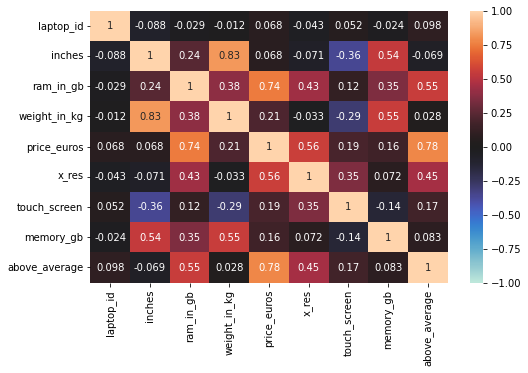

In [38]:
figure = plt.figure(figsize=(8,5))
sns.heatmap(df.corr(),vmin=-1,center=0,vmax=1,annot=True)

Convert everything into numeric and see the correlation

In [39]:
encode = LabelEncoder()

In [40]:
df_num = df.copy()
for col in df_num.columns:
    df_num[col] = encode.fit_transform(df_num[col])

In [41]:
df_num.head()

,laptop_id,company,product,type_name,inches,cpu,ram_in_gb,gpu,op_sys,weight_in_kg,price_euros,y_res,x_res,touch_screen,screen_resolution_type,processor,clock_speed_ghz,hard_disk_type,memory_gb,above_average
0,0,1,289,4,7,53,3,58,4,37,524,4,8,0,2,40,16,2,4,1
1,1,1,288,4,7,51,3,51,4,34,342,9,1,0,2,40,9,0,4,0
2,2,7,50,3,14,62,3,53,5,72,168,0,3,0,1,46,18,2,7,0
3,3,1,289,4,13,73,5,9,4,69,745,5,10,0,2,54,21,2,10,1
4,4,1,289,4,7,55,3,59,4,37,637,4,8,0,2,40,26,2,7,1


In [42]:
df_num.corr()

,laptop_id,company,product,type_name,inches,cpu,ram_in_gb,gpu,op_sys,weight_in_kg,price_euros,y_res,x_res,touch_screen,screen_resolution_type,processor,clock_speed_ghz,hard_disk_type,memory_gb,above_average
laptop_id,1.000000,0.112377,0.027740,-0.083174,-0.079075,-0.031849,-0.059045,-0.004907,0.074740,-0.025287,0.071774,0.092660,-0.041915,0.051547,0.105285,-0.043142,0.108641,-0.072085,-0.025298,0.098451
company,0.112377,1.000000,0.032530,-0.027247,-0.055414,0.040047,0.090004,0.055956,0.217338,-0.119122,0.182401,-0.133810,0.052789,0.023923,-0.119395,0.020506,0.153464,0.167333,-0.042957,0.163962
product,0.027740,0.032530,1.000000,0.061698,-0.211070,0.136616,0.057314,0.091214,0.125935,-0.260451,0.200797,-0.065058,0.170029,0.203601,-0.050935,0.136528,-0.044757,0.220793,-0.168101,0.159033
type_name,-0.083174,-0.027247,0.061698,1.000000,-0.025371,-0.122668,-0.218998,-0.219079,0.019763,-0.225018,-0.127454,0.136244,-0.076055,-0.417188,0.141203,-0.118558,-0.102799,0.043512,-0.252094,-0.111790
inches,-0.079075,-0.055414,-0.211070,-0.025371,1.000000,0.042651,0.147186,0.180075,0.096209,0.846909,-0.064207,-0.066440,-0.129419,-0.390961,-0.149756,0.028666,0.317203,-0.252512,0.519893,-0.130655
cpu,-0.031849,0.040047,0.136616,-0.122668,0.042651,1.000000,0.549761,0.460128,0.097634,0.083041,0.595289,-0.320077,0.352849,0.140509,-0.356863,0.994382,0.171721,0.255286,0.303262,0.455567
ram_in_gb,-0.059045,0.090004,0.057314,-0.218998,0.147186,0.549761,1.000000,0.431988,0.164737,0.214365,0.765207,-0.373905,0.484089,0.138358,-0.452880,0.510720,0.434683,0.349492,0.458561,0.616652
gpu,-0.004907,0.055956,0.091214,-0.219079,0.180075,0.460128,0.431988,1.000000,0.136916,0.297471,0.462087,-0.221943,0.220029,0.002413,-0.322632,0.449140,0.325882,0.110910,0.272917,0.352362
op_sys,0.074740,0.217338,0.125935,0.019763,0.096209,0.097634,0.164737,0.136916,1.000000,0.043018,0.286227,-0.180030,0.091301,0.017286,-0.222795,0.067403,0.218385,0.225422,0.100910,0.227249
weight_in_kg,-0.025287,-0.119122,-0.260451,-0.225018,0.846909,0.083041,0.214365,0.297471,0.043018,1.000000,-0.015488,-0.044424,-0.128447,-0.341345,-0.146892,0.073685,0.324227,-0.300428,0.569385,-0.091027


<AxesSubplot:>

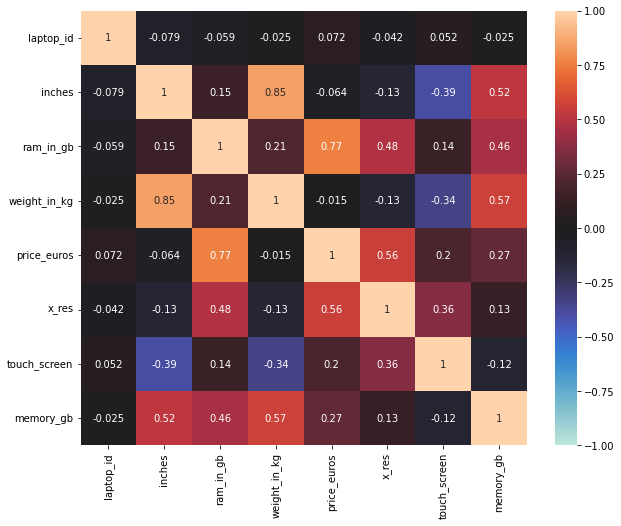

In [43]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(df_num[numerical].corr(),vmin=-1,center=0,vmax=1, annot=True)

Do we really need laptop_id column?? nah! let's remove it

In [44]:
df = df.drop('laptop_id', axis=1)

In [45]:
df.head()

,company,product,type_name,inches,cpu,ram_in_gb,gpu,op_sys,weight_in_kg,price_euros,y_res,x_res,touch_screen,screen_resolution_type,processor,clock_speed_ghz,hard_disk_type,memory_gb,above_average
0,apple,macbook_pro,ultrabook,13.3,intel_core_i5_2.3ghz,8,intel_iris_plus_graphics_640,macos,1.37,1339.69,1600,2560,0,hd_ready,intel_core_i5,2.3,ssd,128,1
1,apple,macbook_air,ultrabook,13.3,intel_core_i5_1.8ghz,8,intel_hd_graphics_6000,macos,1.34,898.94,900,1440,0,hd_ready,intel_core_i5,1.8,hdd,128,0
2,hp,250_g6,notebook,15.6,intel_core_i5_7200u_2.5ghz,8,intel_hd_graphics_620,no_os,1.86,575.00,1080,1920,0,full_hd,intel_core_i5_7200u,2.5,ssd,256,0
3,apple,macbook_pro,ultrabook,15.4,intel_core_i7_2.7ghz,16,amd_radeon_pro_455,macos,1.83,2537.45,1800,2880,0,hd_ready,intel_core_i7,2.7,ssd,512,1
4,apple,macbook_pro,ultrabook,13.3,intel_core_i5_3.1ghz,8,intel_iris_plus_graphics_650,macos,1.37,1803.60,1600,2560,0,hd_ready,intel_core_i5,3.1,ssd,256,1


In [46]:
# base feature(numerical + categorical)
features = df.columns

# Split the columns based on the value attribute
numerical = list(df.dtypes[df.dtypes != 'object'].index)
categorical = list(df.dtypes[df.dtypes == 'object'].index)

### **2.3 Target Variable Analysis**

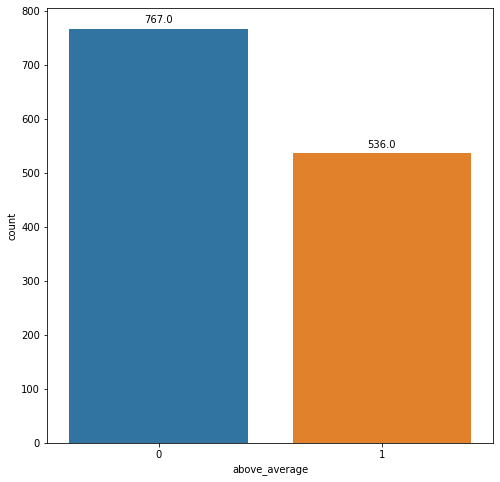

In [47]:
plt.rcParams['figure.figsize']=8,8 
s = sns.countplot(x = "above_average", data = df)
for p in s.patches:
    s.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.show()

In [48]:
df = df.drop('above_average', axis=1)

## 3. Train the Model

#### **Setup the validation framework**

In [49]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train.price_euros.values
y_val = df_val.price_euros.values
y_test = df_test.price_euros.values

del df_train['price_euros']
del df_val['price_euros']
del df_test['price_euros']

In [50]:
df_train.head()

,company,product,type_name,inches,cpu,ram_in_gb,gpu,op_sys,weight_in_kg,y_res,x_res,touch_screen,screen_resolution_type,processor,clock_speed_ghz,hard_disk_type,memory_gb
0,dell,xps_13,ultrabook,13.3,intel_core_i7_7560u_2.4ghz,8,intel_iris_plus_graphics_640,windows_10,1.23,1080,1920,0,full_hd,intel_core_i7_7560u,2.4,ssd,256
1,hp,17-bs001nv_(i5-7200u/6gb/2tb/radeon,notebook,17.3,intel_core_i5_7200u_2.5ghz,6,amd_radeon_520,windows_10,2.71,1080,1920,0,full_hd,intel_core_i5_7200u,2.5,hdd,2000
2,dell,latitude_5480,notebook,14.0,intel_core_i5_7200u_2.5ghz,4,intel_hd_graphics_620,windows_10,1.60,768,1366,0,hd_ready,intel_core_i5_7200u,2.5,hdd,500
3,dell,xps_13,ultrabook,13.3,intel_core_i5_8250u_1.6ghz,8,intel_uhd_graphics_620,windows_10,1.20,1080,1920,0,full_hd,intel_core_i5_8250u,1.6,ssd,256
4,dell,alienware_15,gaming,15.6,intel_core_i7_6700hq_2.6ghz,16,nvidia_geforce_gtx_970m,windows_10,3.21,2160,3840,0,4k,intel_core_i7_6700hq,2.6,hybrid,1256


In [51]:
from sklearn.feature_extraction import DictVectorizer

In [52]:
dv = DictVectorizer()

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [53]:
train_dict[0]

{'company': 'dell',
 'product': 'xps_13',
 'type_name': 'ultrabook',
 'inches': 13.3,
 'cpu': 'intel_core_i7_7560u_2.4ghz',
 'ram_in_gb': 8,
 'gpu': 'intel_iris_plus_graphics_640',
 'op_sys': 'windows_10',
 'weight_in_kg': 1.23,
 'y_res': '1080',
 'x_res': 1920,
 'touch_screen': 0,
 'screen_resolution_type': 'full_hd',
 'processor': 'intel_core_i7_7560u',
 'clock_speed_ghz': '2.4',
 'hard_disk_type': 'ssd',
 'memory_gb': 256}

In [54]:
scores = []
au_scores = []

### **Model - 1 Linear Regression**

In [55]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [56]:
y_pred = lr.predict(X_val)

In [57]:
lr_score = lr.score(X_val, y_val)
scores.append(lr_score)

Text(0, 0.5, 'Predicted Values')

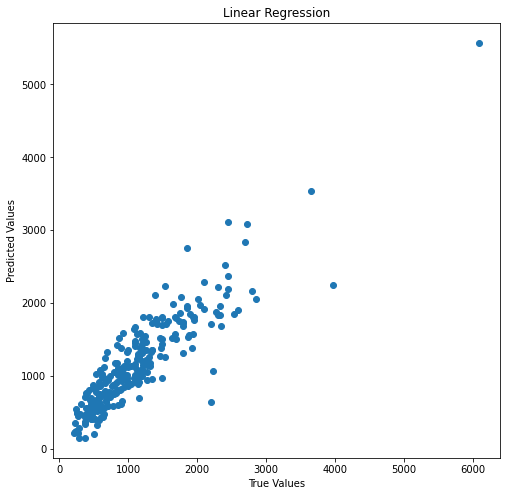

In [58]:
plt.scatter(y_val,y_pred)
plt.title('Linear Regression')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

#### **Cross-Validation/Parameter Tuning**

In [59]:
from sklearn.model_selection import cross_val_score, KFold
cross_scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
cross_scores

array([0.69298891, 0.86224003, 0.77368759, 0.75738456, 0.79985877])

In [60]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
cross_scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=folds)
cross_scores  

array([0.69569259, 0.82264479, 0.75060307, 0.81769409, 0.80222014])

### **Model - 2 DecisionTree Regression**

In [61]:
from sklearn.tree import DecisionTreeRegressor
Dt = DecisionTreeRegressor()
Dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [62]:
# Predicting the test set 
dt_pred = Dt.predict(X_val)

In [63]:
dt_score = Dt.score(X_val, y_val)

scores.append(dt_score)

### **Model - 3 XGBoost Regression**

In [64]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=15,max_depth=3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=15, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [65]:
xgb_pred = xgb.predict(X_val)

In [66]:
xgb_score = xgb.score(X_val, y_val)

scores.append(xgb_score)

### **Model - 4 RandomForest Regression**

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
list1 = []
for estimator in range(10,50):
    rf = RandomForestRegressor(n_estimators=estimator)
    rf.fit(X_train,y_train)
    rf_pred = rf.predict(X_val)
    rf_score = rf.score(X_val, y_val)
    list1.append(rf_score)

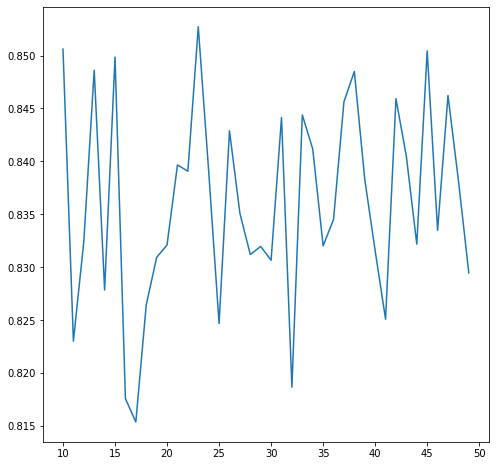

In [69]:
plt.plot(list(range(10,50)), list1)
plt.show()

In [70]:
rf = RandomForestRegressor(n_estimators=30)
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_val)

rf_score = rf.score(X_val, y_val)
scores.append(rf_score)

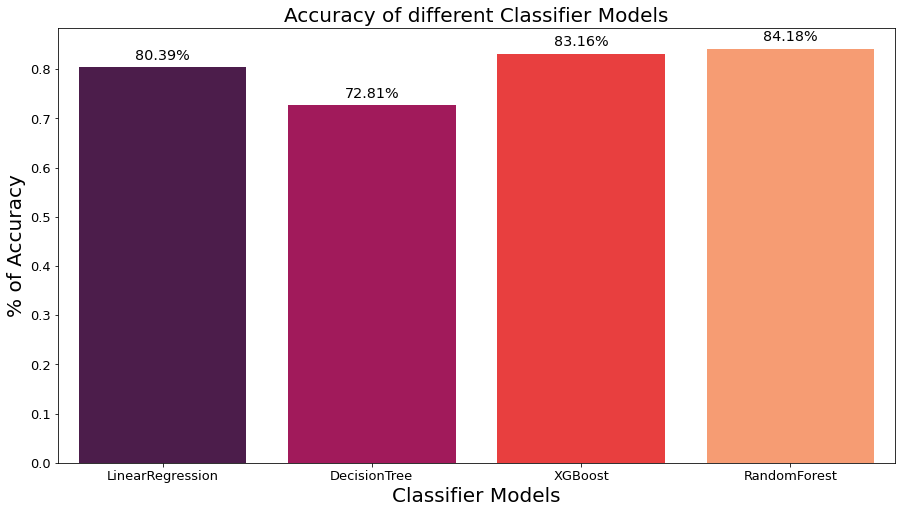

In [71]:
models = ['LinearRegression','DecisionTree','XGBoost','RandomForest']
# Visualising the accuracy score of each classification model
plt.rcParams['figure.figsize']=15,8 
ax = sns.barplot(x=models, y=scores, palette = "rocket", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

RandomForest gives better result among the four model so will use the **RandomForestClassifier** as our final model